In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
import seaborn as sns
from math import log

# Je me positionne dans mon répertoire de travail personnel
os.chdir("C:\\Users\\Julien Gremillot\\OneDrive\\Documents\\OpenClassrooms\\Segmentez des clients d'un site e-commerce")
os.getcwd()

# Lecture du fichier issu de l'analyse exploratoire
clients = pd.read_csv("client_infos.csv")

In [2]:
clients.shape

(96093, 29)

In [3]:
clients.head()

,vouchers_value,boleto_value,debit_card_value,sum_payments,sum_freight_value,nb_items,fashion,diy,home,hightech,...,favorite_hour,avg_review_score,avg_review_len,avg_popularite,avg_product_name_lenght,avg_product_description_lenght,avg_product_photos_qty,order_purchase_timestamp,time_since_last_order,delivery_time
0,0.0,0.0,0.0,141.90,12.00,1.0,0.0,0.0,1.0,0.0,...,10,5.0,111.0,2.408850,60.0,236.0,1.0,1.525950e+09,160,553930.0
1,0.0,0.0,0.0,27.19,8.29,1.0,1.0,0.0,0.0,0.0,...,11,4.0,0.0,0.337230,56.0,635.0,1.0,1.525691e+09,163,283875.0
2,0.0,0.0,0.0,86.22,17.22,1.0,0.0,0.0,1.0,0.0,...,21,3.0,0.0,0.148901,49.0,177.0,3.0,1.489180e+09,585,2223224.0
3,0.0,0.0,0.0,43.62,17.63,1.0,0.0,0.0,0.0,1.0,...,20,4.0,12.0,-0.039428,43.0,1741.0,5.0,1.507840e+09,369,1731204.0
4,0.0,0.0,0.0,196.89,16.89,1.0,0.0,0.0,0.0,1.0,...,19,5.0,0.0,-0.227757,58.0,794.0,3.0,1.510689e+09,336,1135394.0


In [4]:
clients.dtypes

vouchers_value                    float64
boleto_value                      float64
debit_card_value                  float64
sum_payments                      float64
sum_freight_value                 float64
nb_items                          float64
fashion                           float64
diy                               float64
home                              float64
hightech                          float64
culture                           float64
leisure                           float64
games                             float64
food                              float64
misc                              float64
nb_orders                           int64
nb_week_orders                      int64
nb_weekend_orders                   int64
favorite_dayofweek                  int64
favorite_hour                       int64
avg_review_score                  float64
avg_review_len                    float64
avg_popularite                    float64
avg_product_name_lenght           

La segmentation RFM ou méthode RFM est une méthode de segmentation principalement développée à l'origine pour les actions de marketing direct des véadistes et qui s'applique désormais également aux acteurs du e-commerce et du commerce traditionnel.

La segmentation RFM prend en compte la Récence (date de la dernière commande), la Fréquence des commandes et le Montant (de la dernière commande ou sur une période donnée) pour établir des segments de clients homogènes.

La segmentation RFM permet de cibler les offres, d'établir des segments basés sur la valeur des clients et de prévenir l'attrition en identifiant des segments à risque.

Dans notre jeu de données, on a donc :
- la Récence qui correspond à notre colonne 'time_since_last_order'.
- la Fréquence qui correspond à notre colonne 'nb_orders'.
- le Montant qui correspond à notre colonne 'sum_payments'.

Pour chacune de ces variables on va vérifier la distribution.

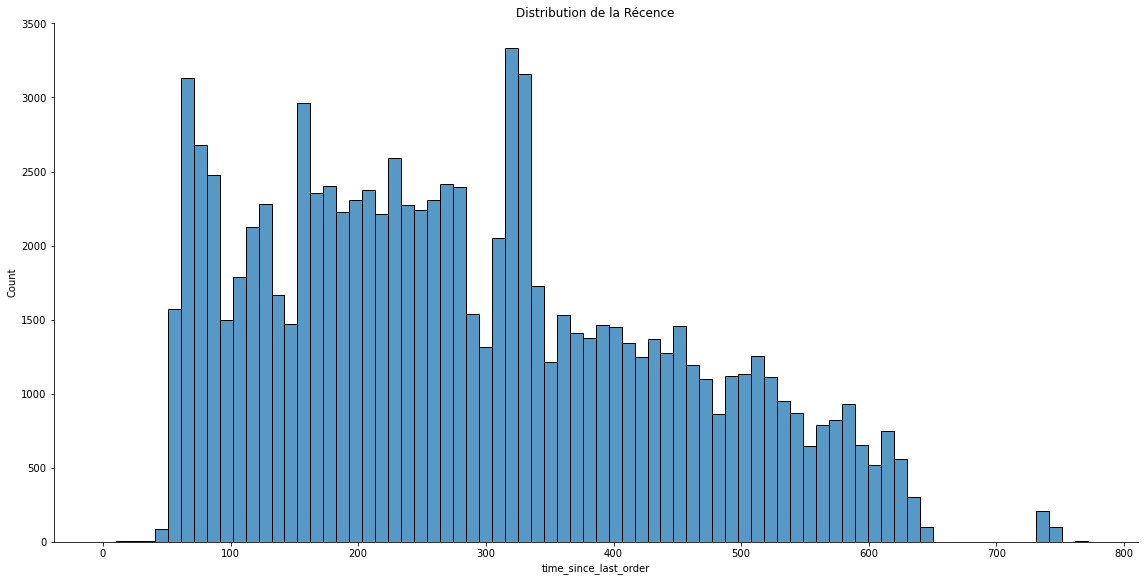

In [5]:
sns.displot(clients, x="time_since_last_order", height=8, aspect=2).set(
    title='Distribution de la Récence')

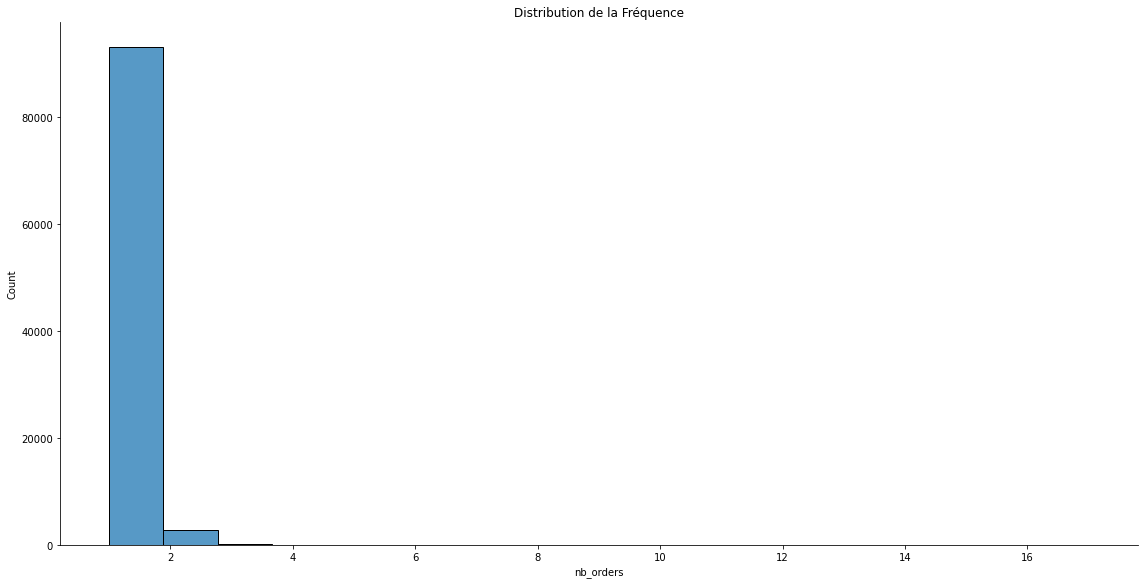

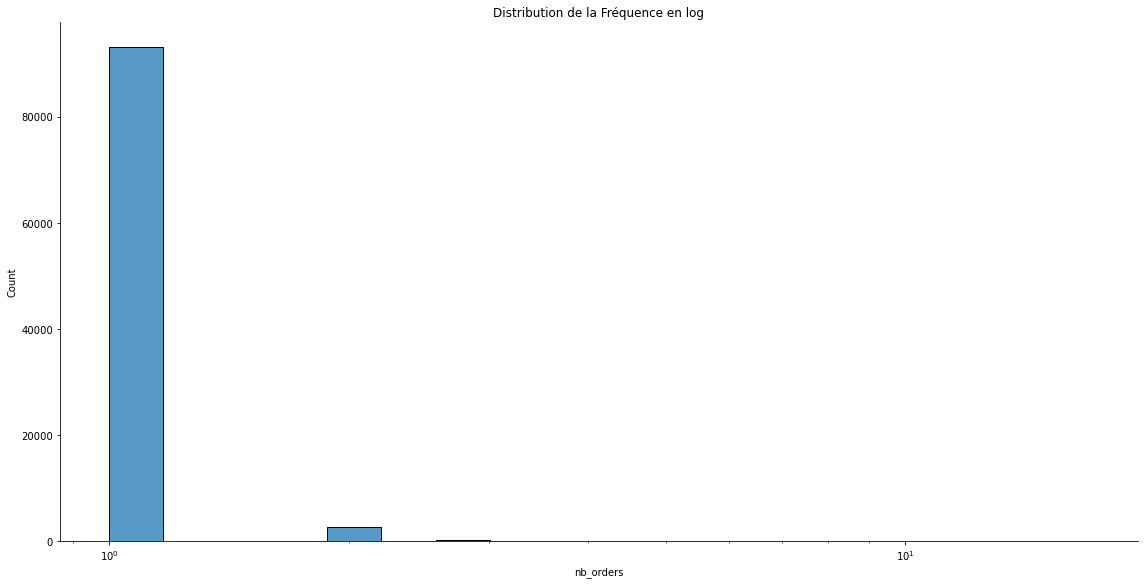

In [6]:
sns.displot(clients, x="nb_orders", height=8, aspect=2).set(title='Distribution de la Fréquence')
sns.displot(clients, x="nb_orders", log_scale=True, height=8, aspect=2).set(title='Distribution de la Fréquence en log')

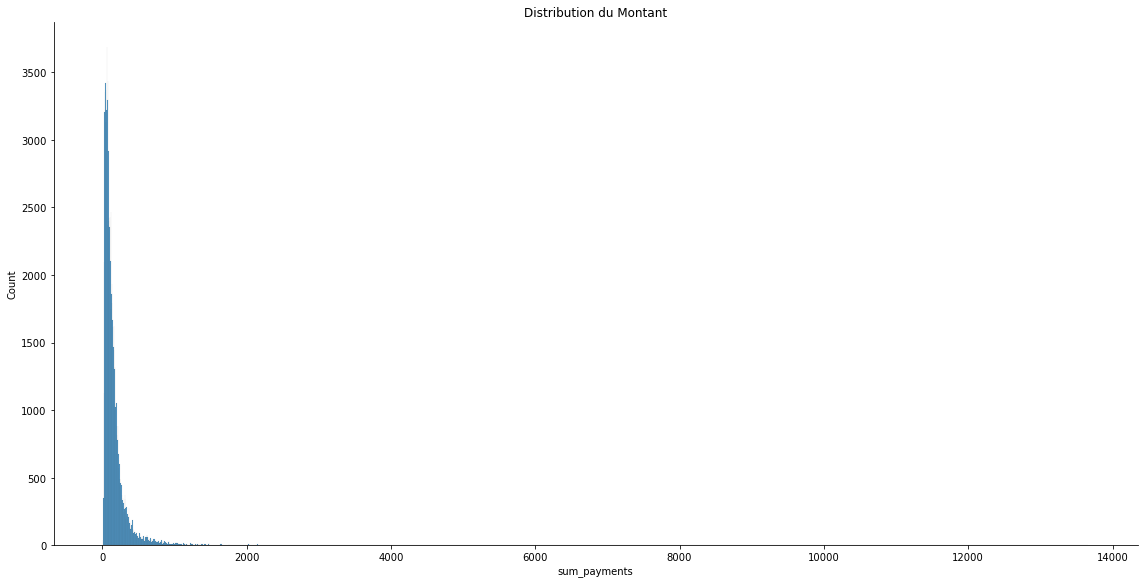

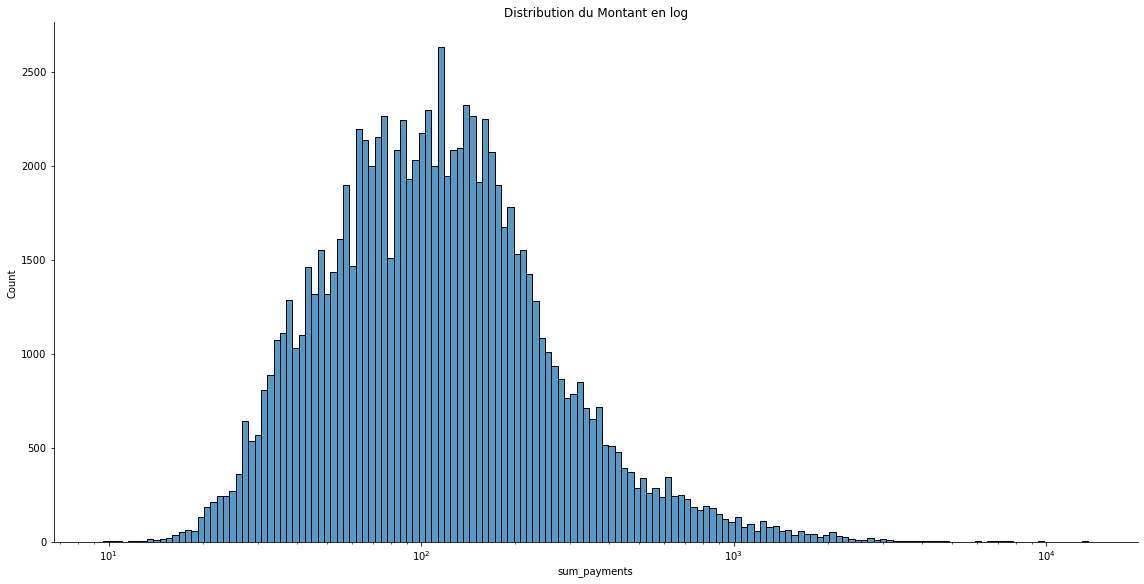

In [7]:
sns.displot(clients, x="sum_payments", height=8, aspect=2).set(title='Distribution du Montant')
sns.displot(clients, x="sum_payments", log_scale=True, height=8, aspect=2).set(title='Distribution du Montant en log')

On constate que la Récence est plutôt bien distribuée, que la Fréquence ne l'est pas vraiment mais qu'un passage au log ne change rien. Le passage au log est surtout intéressant pour le Montant, on change donc le contenu de la colonne "sum_payments".

In [8]:
clients['sum_payments'] = [log(p) for p in clients['sum_payments']]

Standardisation des données clients :

In [9]:
scaler = StandardScaler()
clients_std = scaler.fit_transform(clients)

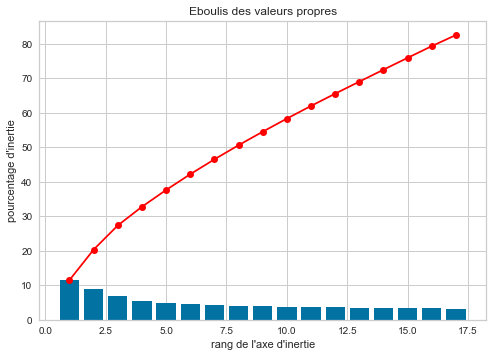

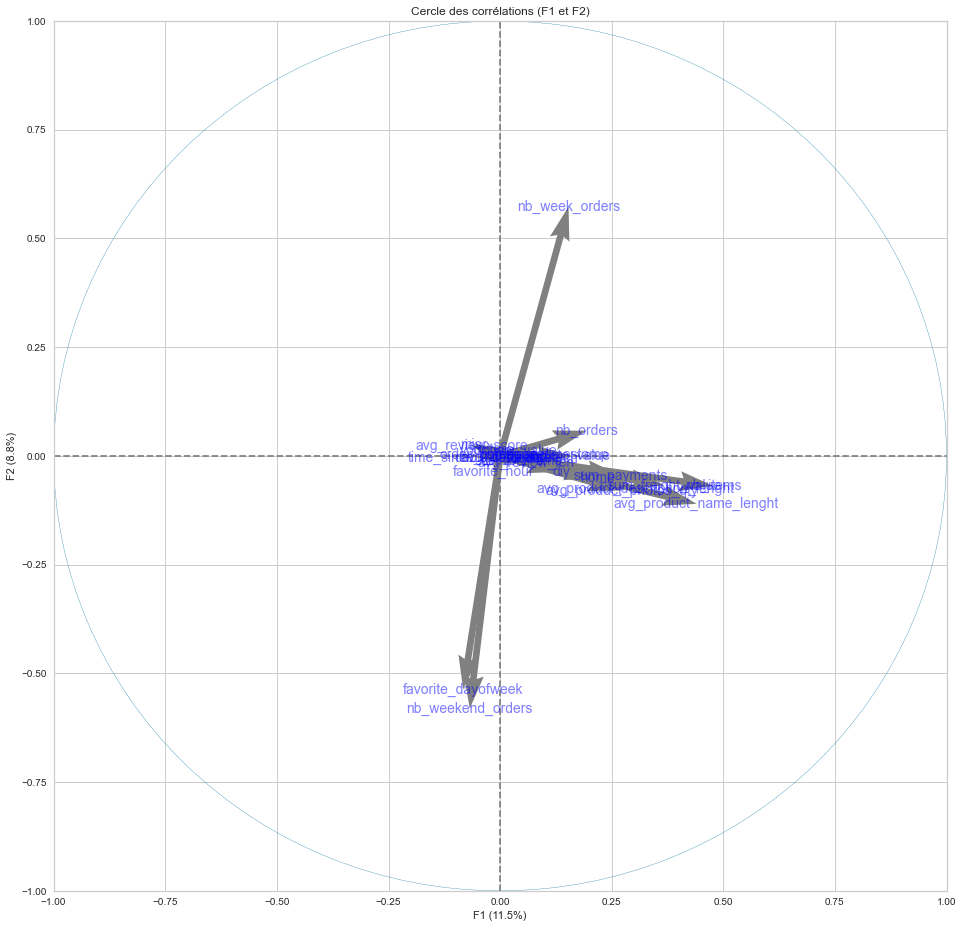

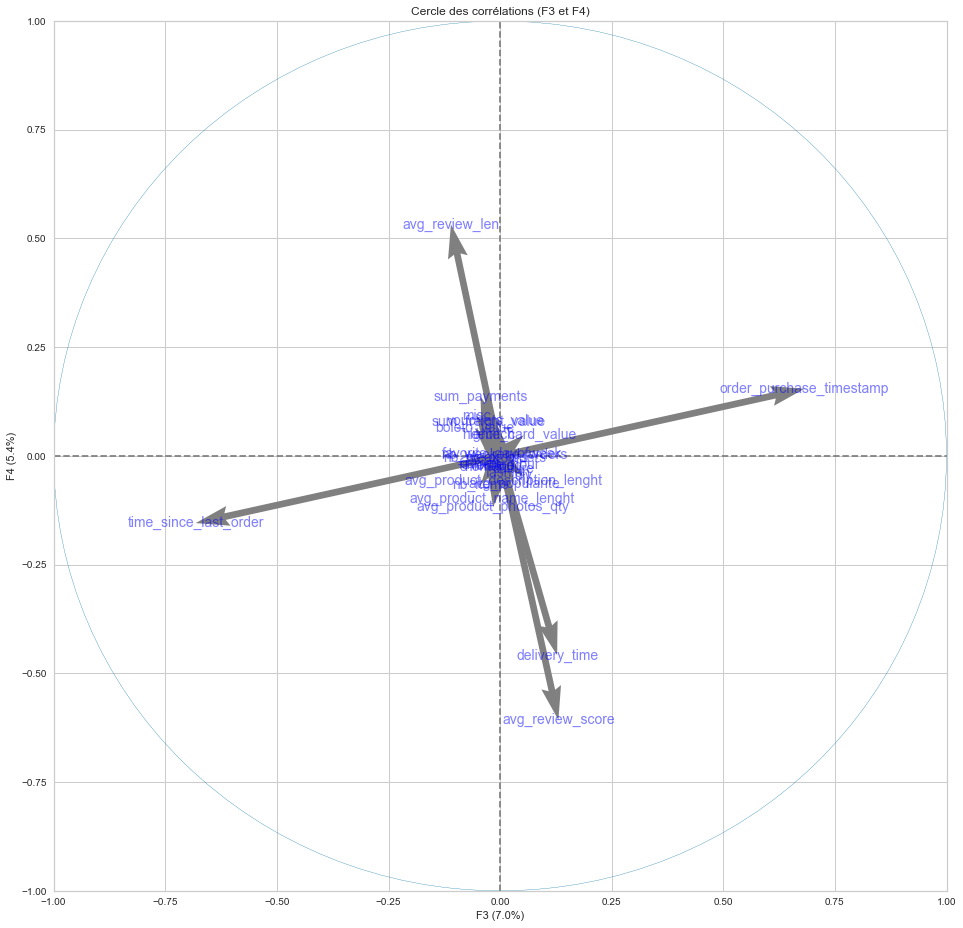

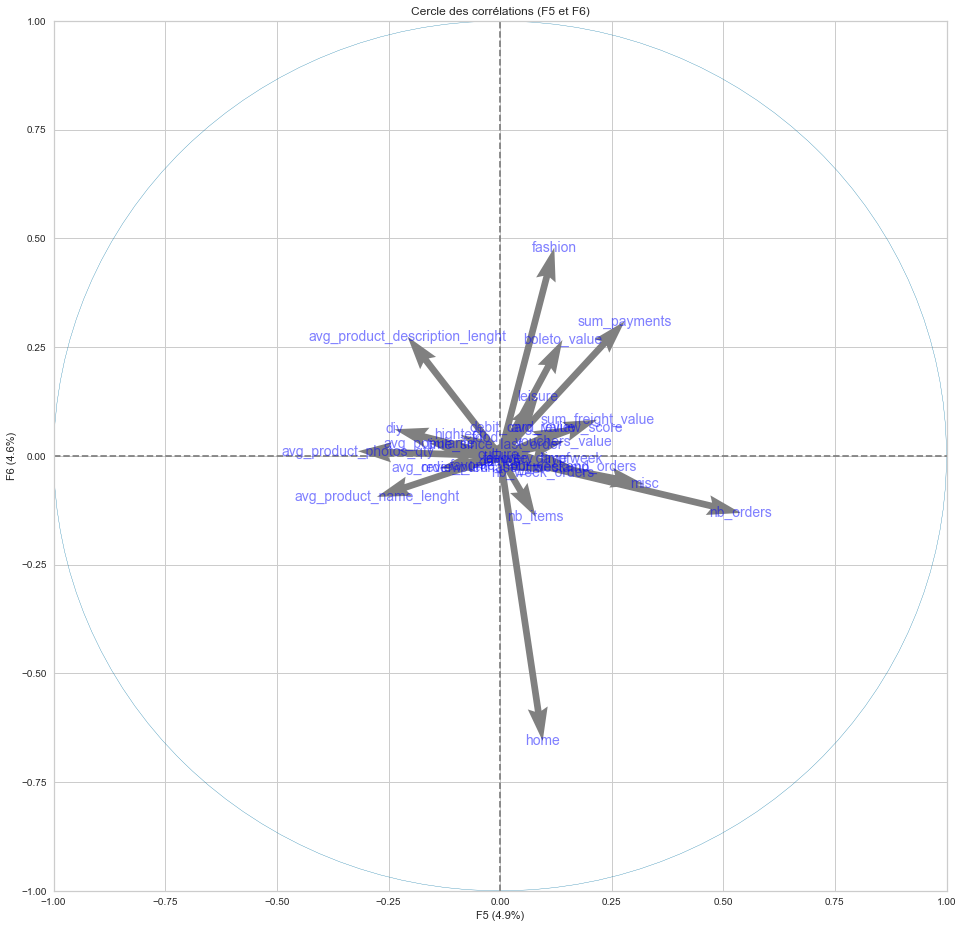

In [23]:
# Ici on ne connait pas le nombre de composantes à calculer, on demande à scikit-learn de conserver 80% de la variance. 
pca = PCA(0.8)
data_pca = pca.fit_transform(clients_std)

# Eboulis des valeurs propres - on utilise la fonction d'un projet précédent
from functions import *
display_scree_plot(pca)

pcs = pca.components_

n_comp = 6
axis_ranks = [(0,1),(2,3),(4,5)]
labels = np.array(clients.columns)

for d1, d2 in axis_ranks: # On affiche les premiers plans factoriels
    if d2 < n_comp:
        
        # initialisation de la figure
        fig, ax = plt.subplots(figsize=(16,16))

        # détermination des limites du graphique
        if pcs.shape[1] < 30 :
            xmin, xmax, ymin, ymax = -1, 1, -1, 1
        else :
            xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

        # affichage des flèches
        # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
        if pcs.shape[1] < 30 :
            plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
               pcs[d1,:], pcs[d2,:], 
               angles='xy', scale_units='xy', scale=1, color="grey")
            # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
        else:
            lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
            ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))

        # affichage des noms des variables  
        if labels is not None:  
            for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                    plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=0, color="blue", alpha=0.5)

        # affichage du cercle
        circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
        plt.gca().add_artist(circle)

        # définition des limites du graphique
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

        # affichage des lignes horizontales et verticales
        plt.plot([-1, 1], [0, 0], color='grey', ls='--')
        plt.plot([0, 0], [-1, 1], color='grey', ls='--')

        # nom des axes, avec le pourcentage d'inertie expliqué
        plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
        plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

        plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
        plt.show(block=False)

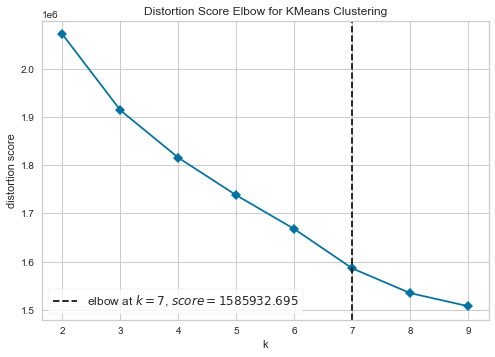

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
clients_cluster = cluster.KMeans()
from yellowbrick.cluster import KElbowVisualizer
k_elbow_visualizer = KElbowVisualizer(clients_cluster, k=(2, 10), timings=False)
k_elbow_visualizer.fit(data_pca)
k_elbow_visualizer.show()

La méthode du coude nous donne un k optimal pour une valeur de 7 (même si graphiquement le "coude" n'est pas très marqué).

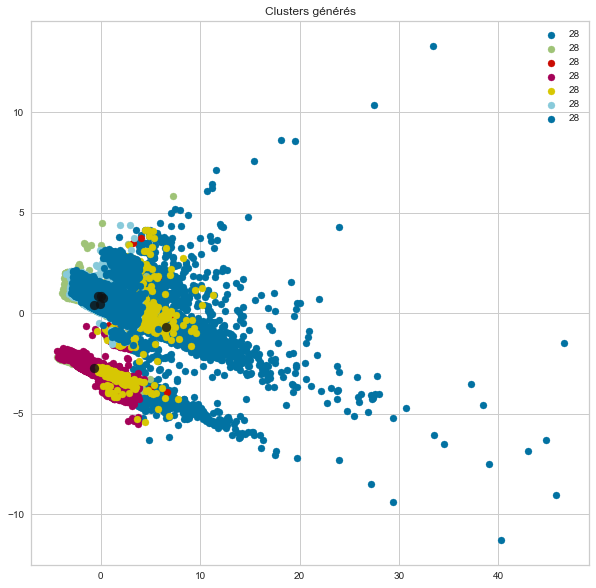

In [27]:
kmeans = cluster.KMeans(n_clusters=7)
label = kmeans.fit_predict(data_pca)
cluster_centers = kmeans.cluster_centers_
plt.figure(figsize=(10, 10))
for l in np.unique(labels):
    plt.scatter(data_pca[label==l, 0], data_pca[label==l, 1], label = i)
plt.scatter(cluster_centers[:, 0], cluster_centers[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Clusters générés')
plt.show()